# CounterFactual Experiment

## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import itertools
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.utils import Bunch
from typing import cast
from CounterFactualModel import CounterFactualModel
from ConstraintParser import ConstraintParser
import CounterFactualVisualizer as CounterFactualVisualizer
importlib.reload(CounterFactualVisualizer)
from CounterFactualVisualizer import (plot_pca_with_counterfactual, plot_sample_and_counterfactual_heatmap, 
                                     plot_pca_loadings, plot_constraints, 
                                     plot_sample_and_counterfactual_comparison, plot_pairwise_with_counterfactual_df,plot_pca_with_counterfactuals)
from CounterFactualExplainer import CounterFactualExplainer

warnings.filterwarnings("ignore")

## Setup + Constants

In [7]:
CLASS_COLORS_LIST = ['purple', 'green', 'orange']
IRIS: Bunch = cast(Bunch, load_iris())
IRIS_FEATURES = IRIS.data
IRIS_LABELS = IRIS.target

TRAIN_FEATURES, TEST_FEATURES, TRAIN_LABELS, TEST_LABELS = train_test_split(IRIS_FEATURES, IRIS_LABELS, test_size=0.3, random_state=42)

MODEL = RandomForestClassifier(n_estimators=3, random_state=42)
MODEL.fit(TRAIN_FEATURES, TRAIN_LABELS)


ORIGINAL_SAMPLE = {'petal width (cm)': 6.1, 'petal length (cm)': 2.8, 'sepal length (cm)': 4.7, 'sepal width (cm)': 1.2}
SAMPLE_DATAFRAME = pd.DataFrame([ORIGINAL_SAMPLE])  # Wrapping sample in a list to create a DataFrame

CONSTRAINT_PARSER = ConstraintParser("constraints/custom_l100_pv0.001_t2_dpg_metrics.txt")
CONSTRAINTS = CONSTRAINT_PARSER.read_constraints_from_file()

cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS, verbose=True)  # Ensure you are using the correct constraints (nested_dict)
TARGET_CLASS = 0
ORIGINAL_SAMPLE_PREDICTED_CLASS = MODEL.predict(SAMPLE_DATAFRAME)

RULES = ['no_change', 'non_increasing', 'non_decreasing']
FEATURES_NAMES = list(ORIGINAL_SAMPLE.keys())
RULES_COMBINATIONS = list(itertools.product(RULES, repeat=len(FEATURES_NAMES)))


## Constraints Extracted from DPG

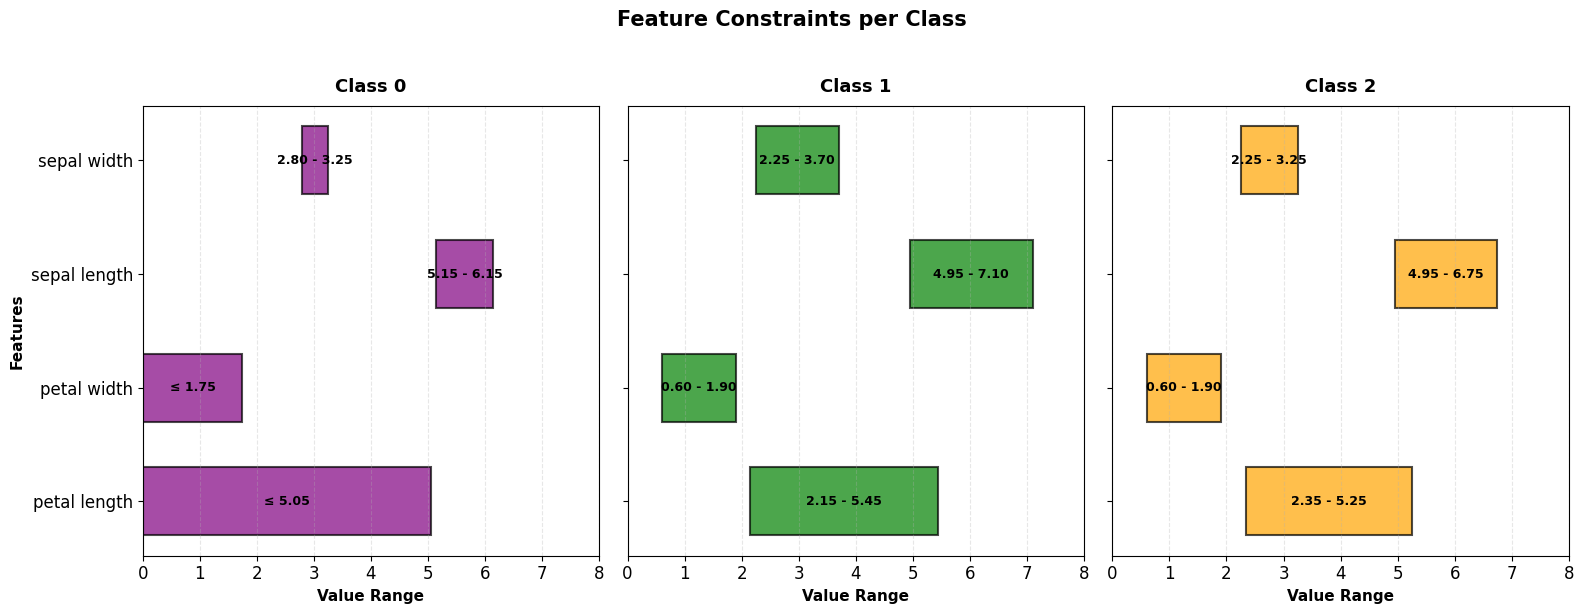

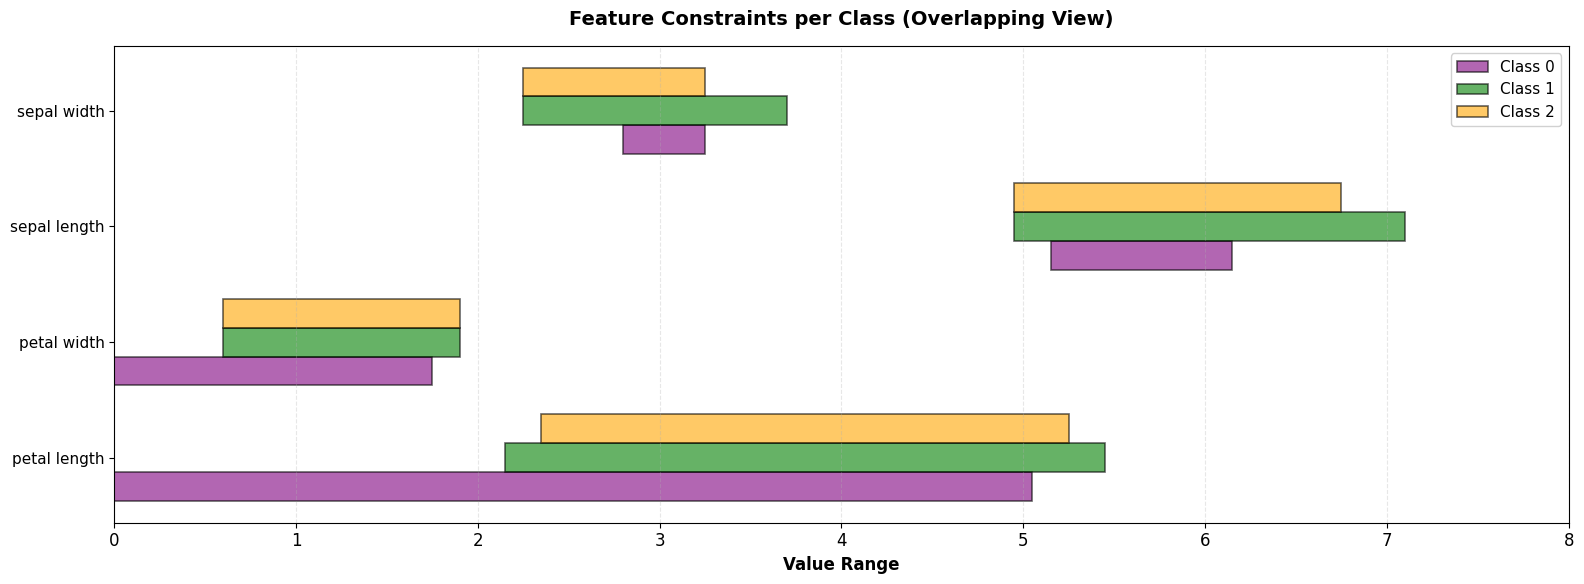

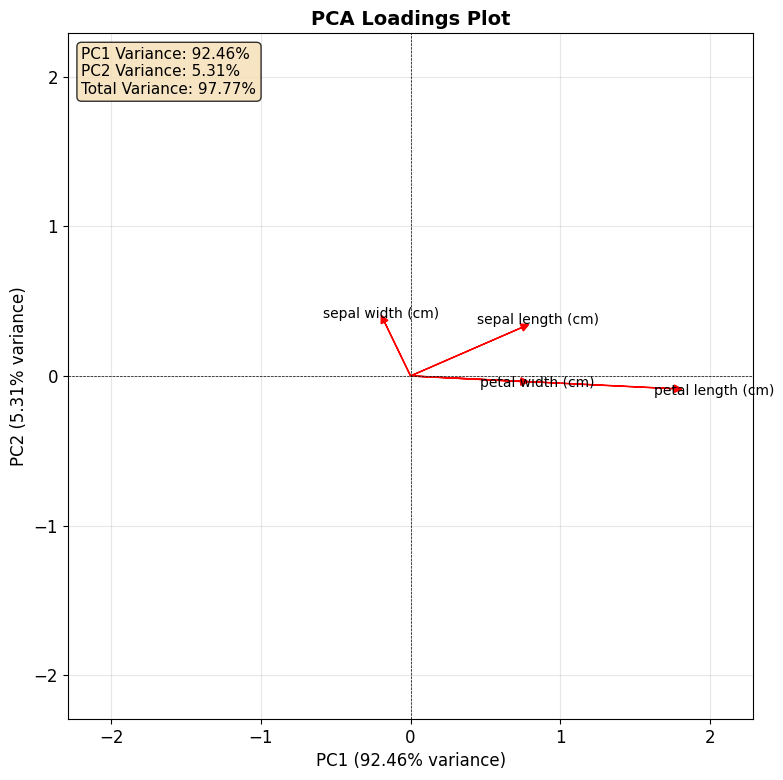

In [8]:

plot_constraints(CONSTRAINTS, overlapping=False, class_colors_list=CLASS_COLORS_LIST)
plot_constraints(CONSTRAINTS, overlapping=True, class_colors_list=CLASS_COLORS_LIST)
plot_pca_loadings(IRIS_FEATURES, IRIS.feature_names)

## Generate Counterfactuals with All Rule Combinations

Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Generating counterfactual with constraints: {'sepal width (cm)': 'non_increasing'}
Gene

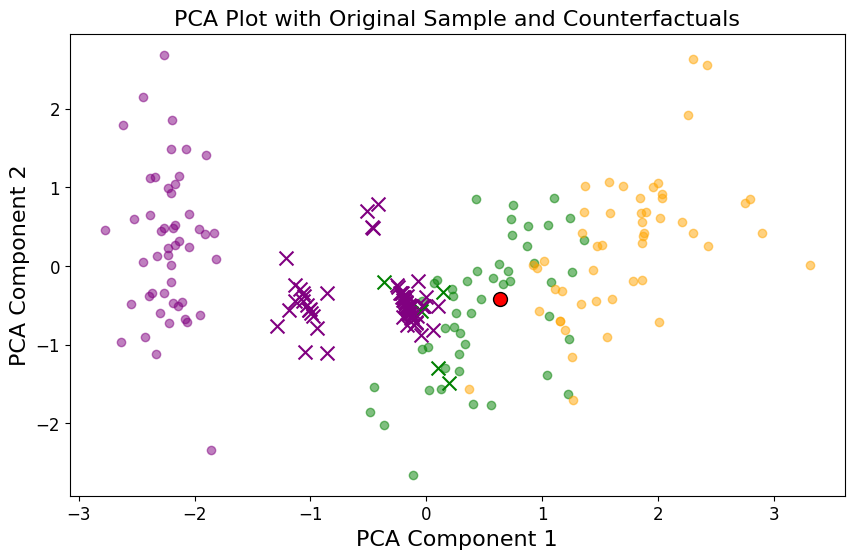

In [9]:

counterfactuals_df_combinations = []

for combination in RULES_COMBINATIONS:
    # dict_non_actionable = dict(zip(FEATURES_NAMES, combination))

    dict_non_actionable = {'sepal width (cm)': 'non_increasing'}



    print(f"Generating counterfactual with constraints: {dict_non_actionable}")
    cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS)
    cf_dpg.dict_non_actionable = dict_non_actionable

    counterfactual = cf_dpg.generate_counterfactual(ORIGINAL_SAMPLE, TARGET_CLASS, 20, 100)
    if (counterfactual == None):
        continue

    # plot_sample_and_counterfactual_heatmap(ORIGINAL_SAMPLE, ORIGINAL_SAMPLE_PREDICTED_CLASS, counterfactual,  MODEL.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
    # cf_dpg.plot_fitness()
    # plot_sample_and_counterfactual_comparison(MODEL, ORIGINAL_SAMPLE, SAMPLE_DATAFRAME, counterfactual, CLASS_COLORS_LIST)


    # explainer = CounterFactualExplainer(cf_dpg, ORIGINAL_SAMPLE, counterfactual, TARGET_CLASS)
    # print(explainer.explain_feature_modifications())
    # print(explainer.check_constraints_respect())
    # print(explainer.explain_stopping_criteria())
    # print(explainer.summarize_final_results())


    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})
    counterfactuals_df_combinations.append(cf_data)

counterfactuals_df_combinations = pd.DataFrame(counterfactuals_df_combinations)

# plot_pairwise_with_counterfactual_df(MODEL, IRIS_FEATURES, IRIS_LABELS, ORIGINAL_SAMPLE, counterfactuals_df_combinations)
plot_pca_with_counterfactuals(MODEL, pd.DataFrame(IRIS_FEATURES), IRIS_LABELS, ORIGINAL_SAMPLE, counterfactuals_df_combinations)


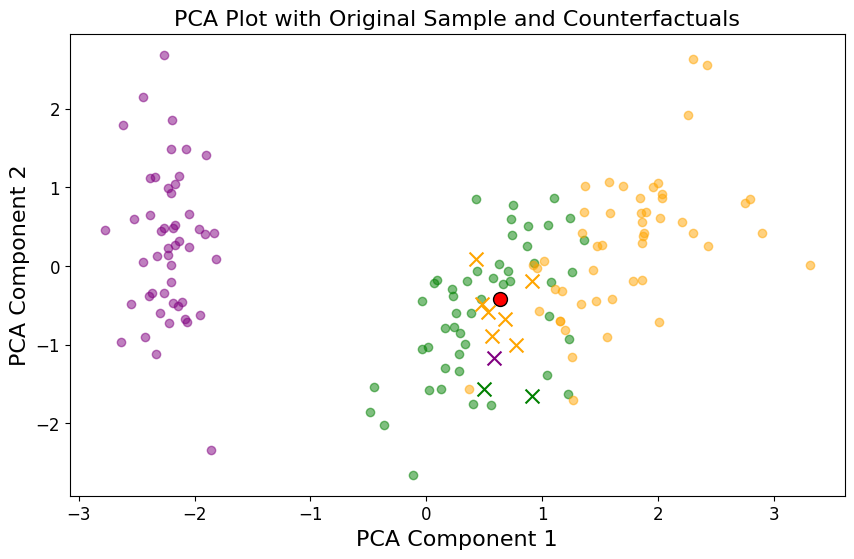

In [ ]:
counterfactuals_df = []
for replicatons in range(10):
    dict_non_actionable = {'sepal width (cm)': 'non_increasing'}

    cf_dpg = CounterFactualModel(MODEL, CONSTRAINTS)
    cf_dpg.dict_non_actionable = dict_non_actionable

    counterfactual = cf_dpg.generate_counterfactual(ORIGINAL_SAMPLE, TARGET_CLASS)
    if (counterfactual == None):
        continue

    # plot_sample_and_counterfactual_heatmap(ORIGINAL_SAMPLE, ORIGINAL_SAMPLE_PREDICTED_CLASS, counterfactual,  MODEL.predict(pd.DataFrame([counterfactual])),  dict_non_actionable)
    # cf_dpg.plot_fitness()
    # plot_sample_and_counterfactual_comparison(MODEL, ORIGINAL_SAMPLE, SAMPLE_DATAFRAME, counterfactual, CLASS_COLORS_LIST)

    # Prepare data for DataFrame
    cf_data = counterfactual.copy()
    cf_data.update({'Rule_' + k: v for k, v in dict_non_actionable.items()})
    counterfactuals_df.append(cf_data)

counterfactuals_df = pd.DataFrame(counterfactuals_df)

# plot_pairwise_with_counterfactual_df(MODEL, IRIS_FEATURES, IRIS_LABELS, ORIGINAL_SAMPLE, counterfactuals_df)
plot_pca_with_counterfactuals(MODEL, pd.DataFrame(IRIS_FEATURES), IRIS_LABELS, ORIGINAL_SAMPLE, counterfactuals_df)
